# Import Libraries

In [1]:
import pandas as pd
import numpy as np

#Use Keras Neural Network Components. This will be used to construct the LSTM
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

#Import Tensorflow 
import tensorflow as tf

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

2023-12-05 00:13:11.704544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Ensure Reproducability of Results

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Fetch and Set Up Data

In [3]:
#Numerically Encode the Activities
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [4]:
DATDIR = "data/UCI HAR Dataset"
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [5]:
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_raw_signal_data(train_test, signal):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/Inertial Signals/{signal}_{'train' if train_test == 0 else 'test'}.txt"
    return pd.read_csv(file_path, delim_whitespace = True, header = None)

#Same purpose as previous function but, in this case, we are fetching ALL the raw signal data!
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_all_raw_signals(train_test):
    data_raw_signals = []
    for signal in SIGNALS:
        raw_signal_data = fetch_raw_signal_data(train_test, signal).to_numpy()
        data_raw_signals.append(raw_signal_data)
    
    data_raw_signals = np.array(data_raw_signals)
    return np.transpose(data_raw_signals, axes = (1, 2, 0))

#Fetch Labels
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_labels(train_test):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/y_{'train' if train_test == 0 else 'test'}.txt"
    return pd.get_dummies(pd.read_csv(file_path, delim_whitespace=True, header = None)[0]).to_numpy()

In [6]:
X_train, X_test, Y_train, Y_test = fetch_all_raw_signals(0), fetch_all_raw_signals(1), fetch_labels(0), fetch_labels(1)

N = X_train.shape[0]
T = X_train.shape[1]
D = X_train.shape[2]

print(N, T, D)

n_classes = Y_train.shape[1]
print(n_classes)

7352 128 9
6


# Define LSTM Architecture

## Use 1 LSTM Layer

In [7]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 32
n_hidden_2 = 16
dropout_p = 0.5

In [8]:
model = Sequential() #Initializing our Model Architecture

# Add an LSTM Layer
model.add(LSTM(n_hidden_1, input_shape = (T, D)))

# Adding a dropout layer
model.add(Dropout(dropout_p))

#Add another Dense Layer
model.add(Dense(n_hidden_2, activation = "relu"))

# Adding a Dense Layer with the Softmax Activation Function
model.add(Dense(n_classes, activation = 'softmax'))

model.summary() #Display a Summary of our model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 6006 (23.46 KB)
Trainable params: 6006 (23.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 12s 22ms/step - loss: 1.1226 - accuracy: 0.5284 - val_loss: 0.9173 - val_accuracy: 0.6043
Epoch 2/30
460/460 [==============================] - 10s 21ms/step - loss: 0.7282 - accuracy: 0.6921 - val_loss: 0.7817 - val_accuracy: 0.6820
Epoch 3/30
460/460 [==============================] - 10s 21ms/step - loss: 0.5584 - accuracy: 0.7470 - val_loss: 0.6597 - val_accuracy: 0.7391
Epoch 4/30
460/460 [==============================] - 10s 21ms/step - loss: 0.5023 - accuracy: 0.7806 - val_loss: 0.7512 - val_accuracy: 0.7547
Epoch 5/30
460/460 [==============================] - 10s 21ms/step - loss: 0.4767 - accuracy: 0.7915 - val_loss: 0.6798 - val_accuracy: 0.7581
Epoch 6/30
460/460 [==============================] - 10s 23ms/step - loss: 0.4468 - accuracy: 0.8160 - val_loss: 0.6000 - val_accuracy: 0.7879
Epoch 7/30
460/460 [==============================] - 12s 26ms/step - loss: 0.3561 - accuracy: 0.8731 - val_loss: 0.5173 - val_accuracy:

In [11]:
def generate_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [12]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 1s 7ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_15875/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


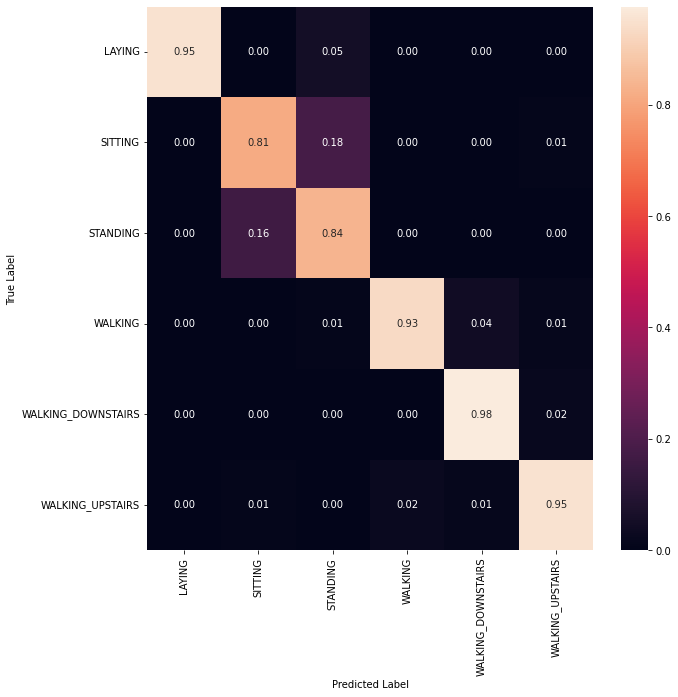

In [13]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [14]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 9ms/step - loss: 0.3653 - accuracy: 0.9077

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.3652690052986145, 0.9077027440071106]


## Use 2 LSTM Layers

In [15]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 64
dropout_p = 0.5
n_hidden_2 = 32
n_hidden_3 = 16

In [16]:
model = Sequential() #Initializing our Model Architecture

#Define LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_1, input_shape=(T, D), return_sequences=True))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define the second LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_2))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define Dense Layer
model.add(Dense(n_hidden_3, activation = 'relu'))

#Define Dense Layer
model.add(Dense(n_classes, activation = 'softmax'))

#Print Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization (Batch  (None, 128, 64)           256       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)               

In [17]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 27s 52ms/step - loss: 0.9308 - accuracy: 0.6359 - val_loss: 0.9114 - val_accuracy: 0.6966
Epoch 2/30
460/460 [==============================] - 26s 56ms/step - loss: 0.4340 - accuracy: 0.8441 - val_loss: 0.3309 - val_accuracy: 0.8968
Epoch 3/30
460/460 [==============================] - 26s 58ms/step - loss: 0.2932 - accuracy: 0.8999 - val_loss: 0.3984 - val_accuracy: 0.8880
Epoch 4/30
460/460 [==============================] - 23s 50ms/step - loss: 0.2333 - accuracy: 0.9221 - val_loss: 0.3232 - val_accuracy: 0.9158
Epoch 5/30
460/460 [==============================] - 23s 50ms/step - loss: 0.2276 - accuracy: 0.9248 - val_loss: 0.5851 - val_accuracy: 0.8571
Epoch 6/30
460/460 [==============================] - 24s 51ms/step - loss: 0.2164 - accuracy: 0.9271 - val_loss: 0.4160 - val_accuracy: 0.8982
Epoch 7/30
460/460 [==============================] - 24s 52ms/step - loss: 0.2394 - accuracy: 0.9246 - val_loss: 0.4661 - val_accuracy:

In [19]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 2s 17ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_15875/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


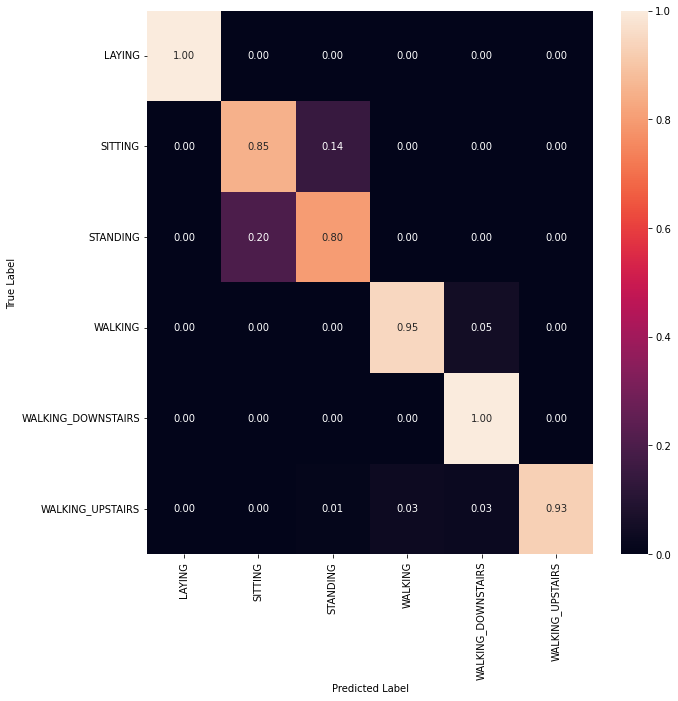

In [20]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [21]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 2s 16ms/step - loss: 0.4041 - accuracy: 0.9186

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.4040808081626892, 0.9185612201690674]
